In [393]:
import numpy as np
np.set_printoptions(precision=4,suppress=True,linewidth=100000)
from itertools import combinations
import cvxpy as cp
from scipy.linalg import circulant
from scipy.stats import rankdata
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import warnings

## Defs:

In [394]:
# primal prices
def prices_primal(V):
    n = V.shape[0]
    assert(n==V.shape[1])
    a = cp.Variable((n,n))
    # objective:
    welfare = cp.sum(cp.multiply(V,a).flatten())
    # constraints:
    unit_demand = cp.sum(a,0) <= 1
    unit_supply  = cp.sum(a,1) <= 1
    ge0 = a >= 0
    le1 = a <= 1
    constraints = [unit_demand, unit_supply, ge0, le1]
    # solve:
    prob = cp.Problem(cp.Maximize(welfare), constraints)
    prob.solve()
    opt_val = prob.value
    p_primal = constraints[0].dual_value
    return p_primal, opt_val

# dual prices
def prices_dual(V, type='default', opt_val=None):
    n = V.shape[0]
    assert(n==V.shape[1])
    assert(type in ['default','min','max'])
    s = cp.Variable(n)
    b = cp.Variable(n)
    # objective:
    if type=='default':
        dual_obj = cp.sum(s)+cp.sum(b)
    elif type=='min':
        dual_obj = cp.sum(s)
    elif type=='max':
        dual_obj = cp.sum(b)
    # constraints:
    dual_ge0_s = s >= 0
    dual_ge0_b = b >= 0
    dual_constraints = [dual_ge0_s, dual_ge0_b]
    if type in ['min','max']:
        if opt_val is None:
            _, opt_val = prices_primal(V)
        dual_constraints.append(cp.sum(s)+cp.sum(b) == opt_val)
    for i in range(n):
        for j in range(n):
            dual_constraints.append(s[i]+b[j] >= V[j,i])
    # solve:
    dual_prob = cp.Problem(cp.Minimize(dual_obj), dual_constraints)
    dual_prob.solve()
    p_dual = s.value
    return p_dual


# min prices (buyer-optimal)
def prices_min(V,opt_val=None):
    return prices_dual(V,'min')

# max prices (seller-optimal)
def prices_max(V,opt_val=None):
    return prices_dual(V,'max')

def prices_all(V):
    p_primal, opt_val = prices_primal(V)
    p_dual = prices_dual(V)
    p_min = prices_dual(V,'min',opt_val)
    p_max = prices_dual(V,'max',opt_val)
    ps = np.asarray([p_primal,p_dual,p_min,p_max])
    return ps

def prices_range(V, rng=np.arange(0,1.1,0.1)):
    rng = np.asarray(rng)
    p_primal, p_dual, p_min, p_max = prices_all(V)
    rng_min = rng[rng<=0.5]*2
    rng_max = (rng[rng>0.5]-0.5)*2
    ps1 = [(1-alpha)*p_min+alpha*p_primal for alpha in rng_min]
    ps2 = [(1-alpha)*p_primal+alpha*p_max for alpha in rng_max]
    ps = np.asarray(ps1+ps2)
    return ps

In [395]:
def homog_mat(n, noise=0., power=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    clean = np.tile(list(np.arange(n-1,-1,-1)),(n,1))/(n-1) #normalized to [0,1]
    dirty = np.random.uniform(size=(n,n))
    for i in range(n):
        dirty[i,:] = np.sort(dirty[i,:])[::-1]
    mat = (1-noise)*clean + noise*dirty
    if power is not None:
        mat = mat ** float(power)
    return mat

def heterog_mat(n, noise=0., power=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    clean = circulant(list(np.arange(n-1,-1,-1))).T/(n-1) #normalized to [0,1]
    dirty = np.random.uniform(size=(n,n))
    circ = circulant(list(np.arange(n-1,-1,-1))).T
    for i in range(n):
        srt_i = np.sort(dirty[i,:])
        dirty[i][circ[i,:]] = srt_i
        mat = (1-noise)*clean + noise*dirty
    if power is not None:
        mat = mat ** float(power)
    return mat

def mix_mat(n, alpha, noise=0., power=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mat = (1-alpha)*heterog_mat(n,alpha,noise,power,see) + alpha*homog_mat(n,alpha,noise,power,see)
    mat += np.random.uniform(size=mat.shape)*noise
    return mat

In [396]:
def gen_items(n,d,der_alpha=0.2,seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.dirichlet(alpha=[der_alpha]*d, size=(n,))
    return X

def get_prefs(X,V_target):
    (n,d) = X.shape
    B = cp.Variable((n,d))
    objective = cp.norm(B@X.T - V_target,"fro")
    pos_const = B >= 0
    prob = cp.Problem(cp.Minimize(objective),[pos_const])
    prob.solve()
    B_ = B.value
    return B_

def get_mixed_prefs(X1,X2,alpha=0.5,noise=0.,power=None,mix_type='decoupled'):
    if mix_type=='decoupled':
        B, X = get_mixed_prefs_decoupled(X1,X2,alpha,noise,power)
    elif mix_type=='joint':
        B, X = get_mixed_prefs_joint(X1,X2,alpha,noise,power)
    elif mix_type=='merged':
        B, X = get_mixed_prefs_merged(X1,X2,alpha,noise,power)
    return B, X

def get_mixed_prefs_decoupled(X1,X2,alpha=0.5,noise=0.,power=None):
    n = X1.shape[0]
    assert(X2.shape[0]==n)
    V_het = heterog_mat(n,noise,power)
    V_hom = homog_mat(n,noise,power)
    B_het = get_prefs(X1,V_het)
    B_hom = get_prefs(X2,V_hom)
    B_decoup = np.hstack(((1-alpha)*B_het,alpha*B_hom))
    X = np.hstack((X1,X2))
    return B_decoup, X

def get_mixed_prefs_joint(X1,X2,alpha=0.5,noise=0.,power=None):
    n = X1.shape[0]
    assert(X2.shape[0]==n)
    X = np.hstack((X1,X2))
    V_het = heterog_mat(n,noise,power)
    V_hom = homog_mat(n,noise,power)
    V_target = (1-alpha)*V_het + alpha*V_hom
    B_joint = get_prefs(X,V_target)
    return B_joint, X

def get_mixed_prefs_merged(X1,X2,alpha=0.5,noise=0.,power=None):
    assert(X1.shape==X2.shape)
    d = X1.shape[1]
    B, _ = get_mixed_prefs_decoupled(X1,X2,alpha,noise,power)
    B1 = B[:,:d]
    B2 = B[:,d:]
    B_merged = B1+B2
    X = X1+X2
    return B_merged, X

def get_V(B,X):
    return B@X.T

def get_Vobs(B,X,mask,impute='zero'):
    assert(B.shape==X.shape)
    if isinstance(mask, list):
        assert(B.shape[1]==len(mask))
        mask = np.asarray(mask)
    if isinstance(mask, np.ndarray):
        assert(mask.ndim==1)
        assert(B.shape[1]==mask.shape[0])
    X = np.copy(X)
    if impute=='zero':
        X = X*mask
    elif impute=='mean':
        mean_X = np.mean(X,axis=0) #average feature values, averaged over items in market
        X[:,mask==0] = mean_X[mask==0]
    Vobs = get_V(B,X)
    return Vobs

In [397]:
def eval_masks(B,X,p,f,k,impute='zero'):
    assert(B.shape==X.shape)
    d = B.shape[1]
    assert(k <= d)
    V = get_V(B,X)
    scores = []
    min_score = 10**10
    max_score = -10**10
    min_masks = []
    max_masks = []
    for indices in combinations(range(d), k):
        mask = [int(i in indices) for i in range(d)]      
        Vobs = get_Vobs(B,X,mask,impute)
        score = f(V,Vobs,p)
        if score<min_score:
            min_score = score
            min_masks = [mask]
        elif score==min_score:
            min_masks.append(mask)
        if score>max_score:
            max_score = score
            max_masks = [mask]
        elif score==max_score:
            max_masks.append(mask)
        scores.append(score)
    return max_masks, min_masks, scores

def eval_masks_lookup(B,X,p,f1,k,f2,lookup_score,impute='zero'):
    tol = 1e-5
    d = B.shape[1]
    V = get_V(B,X)
    welfs = []
    for i,indices in enumerate(combinations(range(d), k)):
        mask = [int(i in indices) for i in range(d)]      
        Vobs = get_Vobs(B,X,mask,impute)
        score = f1(V,Vobs,p)
        if score<=lookup_score+tol and score>=lookup_score-tol:
            welf = f2(V,Vobs,p)
            welfs.append(welf)
    return(welfs)

def eval_masks_set(B,X,p,f,masks,impute='zero'):
    scores = []
    for mask in masks:
        V = get_V(B,X)
        Vobs = get_Vobs(B,X,mask,impute)
        score = f(V,Vobs,p)
        scores.append(score)
    return np.asarray(scores)

def eval_masks_pobs(B,X,p,f,k):
    assert(B.shape==X.shape)
    d = B.shape[1]
    assert(k <= d)
    V = get_V(B,X)
    P = np.tile(p,(n,1))
    scores = []
    Pobss = []
    masks = []
    for indices in combinations(range(d), k):
        mask = [int(i in indices) for i in range(d)]      
        Vobs = get_Vobs(B,X,mask)
        Pobs = P+(V-Vobs) #new def, so that Pobs>=P always
        score = f(V,Vobs,p)
        scores.append(score)
        Pobss.append(Pobs)
        masks.append(mask)
    return scores, Pobss, masks

In [398]:
def choices(Vobs,p):
    y = np.argmax(Vobs-p, axis=1)
    n = y.shape[0]
    tie_breaker = heterog_mat(n)*1e-7
    V = Vobs + tie_breaker #break ties in rows or columns
    utils = np.asarray([V[i,y[i]]-p[y[i]] for i in range(y.shape[0])])
    y[utils<0] = -1 #no choice
    return y

def alloc(y):
    n = y.shape[0] #assumse n=n'
    a = np.zeros((n,n))
    for i in range(n):
        if y[i]>=0:
            a[i,y[i]] = 1
    z = np.sum(a,0)
    z[z==0] = 1
    a = a/z
    return a
    
def welfare(V,Vobs,p):
    y = choices(Vobs,p)
    a = alloc(y)
    W = np.sum(a * V)
    return W
    
def congestion(Vobs,p):
    y = choices(Vobs,p)
    n = y.shape[0]
    unq = [i for i in np.unique(y) if i != -1] #also removes no choice
    num_chosen_items = len(unq)
    return n-num_chosen_items

def decongestion(V,Vobs,p):
    n = V.shape[0]
    return n-congestion(Vobs,p)

def selection(V,Vobs,p):
    y = choices(Vobs,p)
    n = y.shape[0]
    y[y==-1] = n #null item - append last
    V_ = np.hstack((V, np.zeros((n,1))))
    vals = [V_[i,y[i]] for i in range(n)]
    return np.sum(vals)

def selNdecong(V,Vobs,p,lam=0.5):
    return (1.-lam)*selection(V,Vobs,p) + lam*decongestion(V,Vobs,p)

def sel_proxy(V,Vobs,p):
    y = choices(Vobs,p)
    n = y.shape[0]
    y[y==-1] = n #null item - append last
    p_ = np.append(p, 0)
    vals = [p_[y[i]] for i in range(n)]
    return np.sum(vals)

def sel_proxyNdecong(V,Vobs,p,lam=0.5):
    return (1.-lam)*sel_proxy(V,Vobs,p) + lam*decongestion(V,Vobs,p)

In [399]:
def run_experiment(X1,X2,k,alphas,fs,p_func,B_noise,power,mix_type='decoupled',impute='zero',verbose=0):
    assert(X1.shape==X2.shape)
    n = X1.shape[0]
    d = X1.shape[1]
    Ws = np.zeros((len(alphas),len(fs)))
    all_max_masks = [[None]*len(fs) for _ in range(len(alphas))]
    for i,alpha in enumerate(alphas):
        B, X = get_mixed_prefs(X1,X2,alpha,B_noise,power,mix_type)
        V = get_V(B,X) # ground truth @ full info
        p = p_func(V)
        for j,f in enumerate(fs):
            max_masks, min_masks, scores = eval_masks(B,X,p,f,k,impute)
            max_mask = max_masks[0] #choose some max mask
            W_f = welfare(V,get_Vobs(B,X,max_mask,impute),p)
            Ws[i,j] = W_f
            max_score = np.max(scores)
            max_mask_welfs = eval_masks_set(B,X,p,welfare,max_masks,impute)
            all_max_masks[i][j] = max_mask_welfs
            if verbose>0:
                print(f'{alpha:.2f}',max_mask,f'{max_score:.3f} {W_f:.3f}',f.__name__,np.unique(max_mask_welfs, return_counts=True))
        if verbose>0:
            print()
    return Ws, all_max_masks

In [400]:
def prep_mask_scatter(max_masks,alphas,idx):
    x_ = []
    y_ = []
    for j in range(len(alphas)):
        unqs = list(np.unique(max_masks[j][idx]))
        y_ += unqs
        x_ += [alphas[j]] * len(unqs)
    return x_, y_

def prep_mask_mnmx(max_masks,alphas,idx):
    y_mn = []
    y_mx = []
    for j in range(len(alphas)):
        y_mn.append(np.min(max_masks[j][idx]))
        y_mx.append(np.max(max_masks[j][idx]))
    y_ = [y_mn, y_mx]
    return alphas, y_

In [401]:
# taken from:
# https://github.com/ugolbck/kendall-w
# credit to the owner
def compute_w(data):
    """ Computes kendall's W from a list of rating lists.
    0 indicates no agreement and 1 indicates unanimous agreement.
    Parameters
    ---------
    data : list
        List of lists with shape (n_items * n_annotators)
    Return
    ---------
    W : float
        Kendall's W [0:1]
    Example
    ---------
    annotations = [
        [1, 1, 1, 2], # item 1
        [2, 2, 2, 3], # item 2
        [3, 3, 3, 1], # item 3
    ]
    # Annotator #4 disagrees with the other annotators
    # Annotators #1, #2, #3 agree
    W = kendall_w(annotations)
    # output: 0.4375
    """

    assert isinstance(data, list), "You must pass a python list,\
        {} found".format(type(data))
    assert all(isinstance(x, list) for x in data), "You must pass a list of\
        python lists as input."  # To test
    assert all(isinstance(x[y], int) for x in data for y in range(len(x))), "You must\
        pass a list of lists of integers."  # To test

    # Number of annotators
    m = len(data[0])
    # Tests
    if not all(len(i) == m for i in data):
        raise ValueError("Items must all have the same number of annotators.\
            At least one sublist of argument 'data' has different length than\
            the first sublist.")
    if m <= 1:
        raise ValueError("Kendall's W is irrevelent for only one annotator,\
            try adding more lists to argument 'data'.")
    if m == 2:
        warnings.warn("Kendall's W is adapted to measure agreement between\
            more than two annotators. The results might not be reliable in\
            this case.", Warning)

    # Number of items
    n = len(data)
    # Tests
    if n <= 1:
        raise ValueError("Kendall's W is irrevelent for only one item,\
            try adding more sublists to argument 'data'.")

    # Sum of each item ranks
    sums = [sum(x) for x in data]
    # Mean of ranking sums
    Rbar = sum(sums) / n
    # Sum of squared deviations from the mean
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])

    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W


def kendallW(A):
    ranks = np.apply_along_axis(rankdata, 1, -A)
    W = compute_w(ranks.T.astype(np.int32).tolist()) #transpose from (user,item) to (item,user)
    return W

## save figs to file

In [465]:
dirname = 'graphics'

SAVE = False #True #False

## main results

In [403]:
n = 8
d = 14 
k = 6

impute = 'zero'
mix_type = 'merged'
B_noise = 0
power = None
alphas = np.arange(0,1.1,0.1)
fs = [welfare, selNdecong, decongestion, selection, sel_proxy, sel_proxyNdecong]

pis = [1,3,5,7,9]
seeds = list(range(10))

all_Ws = [[None]*len(pis) for _ in range(len(seeds))]
all_max_masks = [[None]*len(pis) for _ in range(len(seeds))]
for i,seed in enumerate(seeds):
    print('seed:',seed, ', pis:', end='')
    np.random.seed(seed)
    X1 = np.random.uniform(size=(n,d))
    X2 = np.random.uniform(size=(n,d))
    for j,pi in enumerate(pis):
        print(pi, end='')
        p_func = lambda V: prices_range(V)[pi]
        np.random.seed(seed)
        Ws, max_masks = run_experiment(X1,X2,k,alphas,fs,p_func,B_noise,power,mix_type)
        all_Ws[i][j] = Ws
        all_max_masks[i][j] = max_masks
    print()

seed: 0 , pis:13579
seed: 1 , pis:13579
seed: 2 , pis:13579
seed: 3 , pis:13579
seed: 4 , pis:13579
seed: 5 , pis:13579
seed: 6 , pis:13579
seed: 7 , pis:13579
seed: 8 , pis:13579
seed: 9 , pis:13579


In [404]:
params_main = [n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds]
res_main = [all_Ws, all_max_masks]

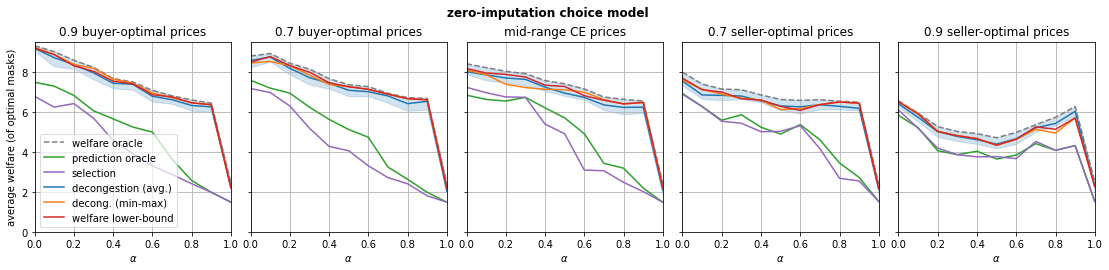

In [464]:
all_Ws, all_max_masks = res_main

decong_idx = 2

names = ['welfare oracle',
         'welfare lower-bound',
         'decongestion (avg.)',
         'prediction oracle',
         'selection',
         'welfare proxy (ours)']
decong_name = 'decong. (min-max)'

colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
titles = ['0.9 buyer-optimal prices','0.7 buyer-optimal prices','mid-range CE prices','0.7 seller-optimal prices','0.9 seller-optimal prices']
xticks = ['0','0.2','0.4','0.6','0.8','1']
order = [0,3,4,2,1,5]

fig, axs = plt.subplots(1,len(pis))
fig.set_size_inches(19,3.5)
for j in range(len(pis)):
    y_ = np.mean(np.asarray([all_Ws[i][j] for i in range(len(seeds))]),0) #average over seeds
    for i in range(len(fs)):
        axs[j].plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]])
    axs[j].set_title(titles[j]) #(f'price_range[{pis[j]:.0f}]')
    axs[j].set_xlabel(r'$\alpha$')
    if j==0:
        axs[j].set_ylabel('average welfare (of optimal masks)')
    else:
        axs[j].set_yticklabels('')
    axs[j].set_ylim(0,9.5)
    axs[j].set_xlim(0,1)
    axs[j].grid()
    if j==0: #len(pis)-1:
#         lgnd = axs[j].legend([names[i_] for i_ in order],bbox_to_anchor=(1.04, 1)) #framealpha=0.4)
        lgnd_names = [names[i_] for i_ in order]
        lgnd_names.insert(4,decong_name)
        lgnd = axs[j].legend(handles=hndls,labels=lgnd_names,framealpha=0.7)

    
clr = colors[decong_idx]
for j in range(len(pis)):
    mnmx = np.asarray([prep_mask_mnmx(all_max_masks[i][j],alphas,decong_idx)[1] for i in range(len(seeds))])
    mn = np.mean(mnmx[:,0,:],axis=0)
    mx = np.mean(mnmx[:,1,:],axis=0)
    axs[j].fill_between(alphas, mn, mx, color=clr, alpha=0.2)
plt.suptitle('zero-imputation choice model', y=1.02, fontweight='bold')
plt.subplots_adjust(wspace=0.1)


if SAVE:
    fname = 'zero_imp'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

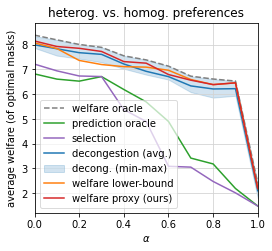

In [380]:
all_Ws, all_max_masks = res_main
n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds = params_main

pi_idx = 2
decong_idx = 2

names = ['welfare oracle',
         'welfare lower-bound',
         'decongestion (avg.)',
         'prediction oracle',
         'selection',
         'welfare proxy (ours)']
decong_name = 'decong. (min-max)'
colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
order = [0,3,4,2,1,5]

fig, axs = plt.subplots(1)
fig.set_size_inches(4,3.5)

y_ = np.mean(np.asarray([all_Ws[i][pi_idx] for i in range(len(seeds))]),0) #average over seeds
hndls = [[]] * len(fs)
for i in range(len(fs)):
    hndls[i], = axs.plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]],label=names[order[i]])
# axs.set_title(f'price_range[{pis[j]:.0f}]')
axs.set_xlabel(r'$\alpha$')
axs.set_ylabel('average welfare (of optimal masks)')
axs.set_title('heterog. vs. homog. preferences')
axs.set_ylim(1.2,8.9)
axs.set_xlim(0,1)
    
clr = colors[decong_idx]
mnmx = np.asarray([prep_mask_mnmx(all_max_masks[i][pi_idx],alphas,decong_idx)[1] for i in range(len(seeds))])
mn = np.mean(mnmx[:,0,:],axis=0)
mx = np.mean(mnmx[:,1,:],axis=0)
hndl_decong = axs.fill_between(alphas, mn, mx, color=clr, alpha=0.2, label=decong_name)
hndls.insert(4,hndl_decong)

lgnd_names = [names[i_] for i_ in order]
lgnd_names.insert(4,decong_name)
lgnd = axs.legend(handles=hndls,labels=lgnd_names,framealpha=0.7) #,bbox_to_anchor=(-0.15, 0.5), loc='center right')

# plt.tight_layout()
plt.grid(color='lightgrey')

if SAVE:
    fname = 'alpha_all'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

### dispersion of decongested solutions (single market)

In [50]:
seed = 0

n = 8
d = 14 
k = 6 

B_noise = 0.
alphas = np.arange(0,1.1,0.1)
fs = [welfare, selNdecong, decongestion, selection, sel_proxy, sel_proxyNdecong]
mix_type = 'merged'
impute = 'zero' #'mean'

pi = 5
p_func = lambda V: prices_range(V)[pi]
power = None

all_Ws = [] 
all_max_masks = [] 
np.random.seed(seed)
X1 = np.random.uniform(size=(n,d))
X2 = np.random.uniform(size=(n,d))

np.random.seed(seed)
Ws, max_masks = run_experiment(X1,X2,k,alphas,fs,p_func,B_noise,power,mix_type,impute)
all_Ws.append(Ws)
all_max_masks.append(max_masks)

In [51]:
params_single = [n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pi, seed]
res_single = [all_Ws, all_max_masks]

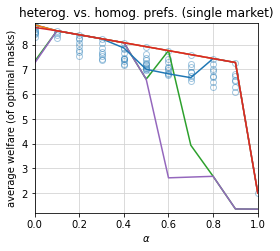

In [381]:
all_Ws, all_max_masks = res_single
n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pi, seed = params_single

decong_idx = 2

names = ['welfare oracle',
         'welfare lower-bound',
         'decongestion (avg.)',
         'prediction oracle',
         'selection',
         'welfare proxy (ours)']
decong_name = 'decong. (all masks)'
colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
order = [0,3,4,2,1,5]

fig, axs = plt.subplots(1)
fig.set_size_inches(4,3.5)

clr = colors[decong_idx]
x_, y_ = prep_mask_scatter(all_max_masks[seed],alphas,decong_idx)
hndl_decong, = axs.plot(x_, y_, 'o', markerfacecolor='none', color=clr, alpha=0.4, label=decong_name)

y_ = all_Ws[seed]
hndls = [[]] * len(fs)
for i in range(len(fs)):
    hndls[i], = axs.plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]],label=names[order[i]])
# axs.set_title('seed ' + str(seed))
axs.set_xlabel(r'$\alpha$')
axs.set_ylabel('average welfare (of optimal masks)')
axs.set_title('heterog. vs. homog. prefs. (single market)')
axs.set_ylim(1.2,8.9)
axs.set_xlim(0,1)

hndls.insert(4,hndl_decong)
lgnd_names = [names[i_] for i_ in order]
lgnd_names.insert(4,decong_name)
# lgnd = axs.legend(handles=hndls,labels=lgnd_names,framealpha=0.7) #,bbox_to_anchor=(-0.15, 0.5), loc='center right')
plt.grid(color='lightgrey')

if SAVE:
    fname = 'alpha_single'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

### joint plot

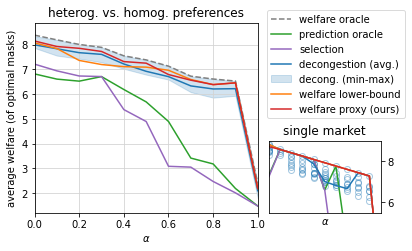

In [382]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pi_idx = 2
decong_idx = 2

names = ['welfare oracle',
         'welfare lower-bound',
         'decongestion (avg.)',
         'prediction oracle',
         'selection',
         'welfare proxy (ours)']
decong_name = 'decong. (min-max)'
colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
order = [0,3,4,2,1,5]


#-----main plot------
all_Ws, all_max_masks = res_main
n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds = params_main


fig, axs = plt.subplots(1)
fig.set_size_inches(4,3.5)

y_ = np.mean(np.asarray([all_Ws[i][pi_idx] for i in range(len(seeds))]),0) #average over seeds
hndls = [[]] * len(fs)
for i in range(len(fs)):
    hndls[i], = axs.plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]],label=names[order[i]])
# axs.set_title(f'price_range[{pis[j]:.0f}]')
axs.set_xlabel(r'$\alpha$')
axs.set_ylabel('average welfare (of optimal masks)')
axs.set_title('heterog. vs. homog. preferences')
axs.set_ylim(1.2,8.9)
axs.set_xlim(0,1)
    
clr = colors[decong_idx]
mnmx = np.asarray([prep_mask_mnmx(all_max_masks[i][pi_idx],alphas,decong_idx)[1] for i in range(len(seeds))])
mn = np.mean(mnmx[:,0,:],axis=0)
mx = np.mean(mnmx[:,1,:],axis=0)
hndl_decong = axs.fill_between(alphas, mn, mx, color=clr, alpha=0.2, label=decong_name)
hndls.insert(4,hndl_decong)

lgnd_names = [names[i_] for i_ in order]
lgnd_names.insert(4,decong_name)
lgnd = axs.legend(handles=hndls,labels=lgnd_names,framealpha=0.7,
#                   bbox_to_anchor=(1.02, 0.55),
                  bbox_to_anchor=(1.02, 0.47),
                  loc='lower left')

# plt.tight_layout()
plt.grid(color='lightgrey')


#-----embedded plot------
all_Ws, all_max_masks = res_single
n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pi, seed = params_single

axins = inset_axes(axs, width="100%", height="100%",
#                    bbox_to_anchor=(1.05, 0., .5, .45),
                   bbox_to_anchor=(1.05, 0., .5, .38),
                   bbox_transform=axs.transAxes, loc=2, borderpad=0)
axins.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, right=True, labelright=True)
# axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
# axins.set_xticks([0.2,0.4,0.6,0.8])

clr = colors[decong_idx]
x_, y_ = prep_mask_scatter(all_max_masks[seed],alphas,decong_idx)
hndl_decong, = axins.plot(x_, y_, 'o', markerfacecolor='none', color=clr, alpha=0.4, label=decong_name)

y_ = all_Ws[seed]
hndls = [[]] * len(fs)
for i in range(len(fs)):
    hndls[i], = axins.plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]],label=names[order[i]])
# axs.set_title('seed ' + str(seed))
axins.set_xlabel(r'$\alpha$')
# axins.set_ylabel('average welfare (of optimal masks)')
# axins.set_title('heterog. vs. homog. prefs. (single instance)')
axins.set_ylim(5.5,9)
axins.set_xlim(0,1)
axins.set_title('single market')
# axins.grid(color='lightgrey')
# axins.legend([r'all $k$-masks'])

if SAVE:
    fname = 'alpha_both'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

## V^power

In [66]:
n = 8
d = 14 
k = 6

impute = 'zero'
mix_type = 'merged'
B_noise = 0.
power = None
alphas = [0.2]
fs = [welfare, selNdecong, decongestion, selection, sel_proxy, sel_proxyNdecong]

pi = 5
powers = 2.0 ** np.arange(-6,0.5,0.5)[::-1]
seeds = list(range(20))

all_Ws = [[None]*len(powers) for _ in range(len(seeds))]
all_max_masks = [[None]*len(powers) for _ in range(len(seeds))]
for i,seed in enumerate(seeds):
    print('seed:',seed, ', power:', end='')
    np.random.seed(seed)
    X1 = np.random.uniform(size=(n,d))
    X2 = np.random.uniform(size=(n,d))
    for j,power in enumerate(powers):
        print(f'2^{np.log2(power):.1f} ', end='')
        p_func = lambda V: prices_range(V)[pi]
        np.random.seed(seed)
        Ws, max_masks = run_experiment(X1,X2,k,alphas,fs,p_func,B_noise,power,mix_type,impute)
        all_Ws[i][j] = Ws
        all_max_masks[i][j] = max_masks
    print()

seed: 0 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 1 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 2 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 3 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 4 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 5 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 6 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 7 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 8 , power:2^0.0 2^-0.5 2^-1.0 2^-1.5 2^-2.0 2^-2.5 2^-3.0 2^-3.5 2^-4.0 2^-4.5 2^-5.0 2^-5.5 2^-6.0 
seed: 9 , power:2^0.0 2^-0.5 2^-1.0 2

In [67]:
params_pow = [n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds]
res_pow = [all_Ws, all_max_masks]

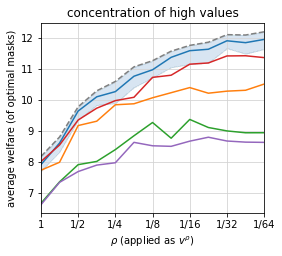

In [383]:
all_Ws, all_max_masks = res_pow
n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds = params_pow

decong_idx = 2

names = ['welfare (oracle)',
         r'$\sum_{ij}y_{ij}v_{ij} + \sum_j \min\{0,1-n_j\}$ (sel+decong)',
         r'$\sum_j \min\{0,1-n_j\}$ (decong.)',
         r'$\sum_{ij}y_{ij}v_{ij}$ (selection)',
         r'$\sum_{ij}y_{ij}p_{j}$ (sel. proxy)',
         r'$\sum_{ij}y_{ij}p_{j} + \sum_j \min\{0,1-n_j\}$ (sel.pxy+decong)']

colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
order = [0,3,4,2,1,5]

fig, axs = plt.subplots(1)
fig.set_size_inches(4,3.5)

clr = colors[decong_idx]
for j in range(len(powers)):
    a_ = [[all_max_masks[i1][i2][0][decong_idx] for i2 in range(len(powers))] for i1 in range(len(seeds))]
    mn = np.mean(np.asarray([[np.min(a_[i2][i1]) for i1 in range(len(powers))] for i2 in range(len(seeds))]),0)
    mx = np.mean(np.asarray([[np.max(a_[i2][i1]) for i1 in range(len(powers))] for i2 in range(len(seeds))]),0)
    axs.fill_between(list(range(len(powers))), mn, mx, color=clr, alpha=0.01)

for i in range(len(fs)):
    y_ = np.mean(np.asarray([[all_Ws[i1][i2][0][order[i]] for i2 in range(len(powers))] for i1 in range(len(seeds))]),0)
    axs.plot(list(range(len(powers))),y_,lnstyls[order[i]],color=colors[order[i]])
axs.set_xlim(0,1)
axs.set_xticks(np.arange(0,len(powers),2))
xticklbls = [f'1/{int(1/powers[j])}' for j in np.arange(0,len(powers),2)]
xticklbls[0] = '1'
axs.set_xticklabels(xticklbls)
axs.set_xlabel(r'$\rho$ (applied as $v^\rho$)')
axs.set_ylabel('average welfare (of optimal masks)')
axs.set_title('concentration of high values')
# lgnd = axs.legend([names[i_] for i_ in order],framealpha=0.4)

plt.grid(color='lightgrey')

if SAVE:
    fname = 'power'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

## distrotion vs. welfare

In [375]:
seed = 0

n = 8
d = 14 
k = 6 #d


impute = 'zero'
mix_type = 'merged'
B_noise = 0
power = None
alphas = np.arange(0,1.1,0.1)
fs = [welfare, selNdecong, decongestion, selection, sel_proxy, sel_proxyNdecong]

alpha = 0.2
pi = 5
p_func = lambda V: prices_range(V)[pi]

np.random.seed(seed)
X1 = np.random.uniform(size=(n,d))
X2 = np.random.uniform(size=(n,d))
B, X = get_mixed_prefs(X1,X2,alpha,B_noise,power,mix_type)
V = get_V(B,X)
p = p_func(V)
P = np.tile(p,(n,1))

scores, Pobss, masks = eval_masks_pobs(B,X,p,welfare,k)
p_dists_norm = np.asarray([np.linalg.norm(Pobs-P,1) for Pobs in Pobss])
kWs = np.asarray([kendallW(V-Pobs) for Pobs in Pobss])

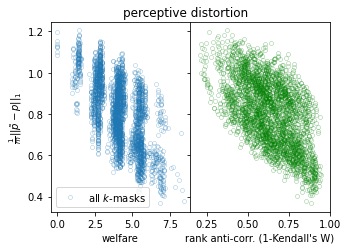

In [390]:
fig,axs = plt.subplots(1,2)
fig.set_size_inches(5,3.5)

axs[0].plot(scores,p_dists_norm/n,'o',markerfacecolor='none',alpha=0.7,markersize=4,markeredgewidth=0.3)
axs[0].set_xlabel('welfare')
axs[0].set_ylabel(r'$\frac{1}{m}\|\|\tilde{p}-p\|\|_1$')
axs[0].legend([r'all $k$-masks'],loc='lower left')

axs[1].plot(1-kWs,p_dists_norm/n,'go',markerfacecolor='none',alpha=0.7,markersize=4,markeredgewidth=0.3)
axs[1].set_xlabel('rank anti-corr. (1-Kendall\'s W)')
# axs[1].set_ylabel(r'$\|\|\tilde{P}-P\|\|_1$')
axs[1].set_xlim(0.15,1)
axs[1].set_yticklabels('')

fig.suptitle('perceptive distortion', y=0.94)
plt.subplots_adjust(wspace=0.)

if SAVE:
    fname = 'scatters'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()

### mean impute

In [412]:
n = 8
d = 14 
k = 6

impute = 'mean'
mix_type = 'merged'
B_noise = 0
power = None
alphas = np.arange(0,1.1,0.1)
fs = [welfare, selNdecong, decongestion, selection, sel_proxy, sel_proxyNdecong]

pis = [1,3,5,7,9]
seeds = list(range(10))

all_Ws = [[None]*len(pis) for _ in range(len(seeds))]
all_max_masks = [[None]*len(pis) for _ in range(len(seeds))]
for i,seed in enumerate(seeds):
    print('seed:',seed, ', pis:', end='')
    np.random.seed(seed)
    X1 = np.random.uniform(size=(n,d))
    X2 = np.random.uniform(size=(n,d))
    for j,pi in enumerate(pis):
        print(pi, end='')
        p_func = lambda V: prices_range(V)[pi]
        np.random.seed(seed)
        Ws, max_masks = run_experiment(X1,X2,k,alphas,fs,p_func,B_noise,power,mix_type,impute)
        all_Ws[i][j] = Ws
        all_max_masks[i][j] = max_masks
    print()

seed: 0 , pis:13579
seed: 1 , pis:13579
seed: 2 , pis:13579
seed: 3 , pis:13579
seed: 4 , pis:13579
seed: 5 , pis:13579
seed: 6 , pis:13579
seed: 7 , pis:13579
seed: 8 , pis:13579
seed: 9 , pis:13579


In [413]:
params_meanimp = [n ,d, k, impute, mix_type, B_noise, power, alphas, fs, pis, seeds]
res_meanimp = [all_Ws, all_max_masks]

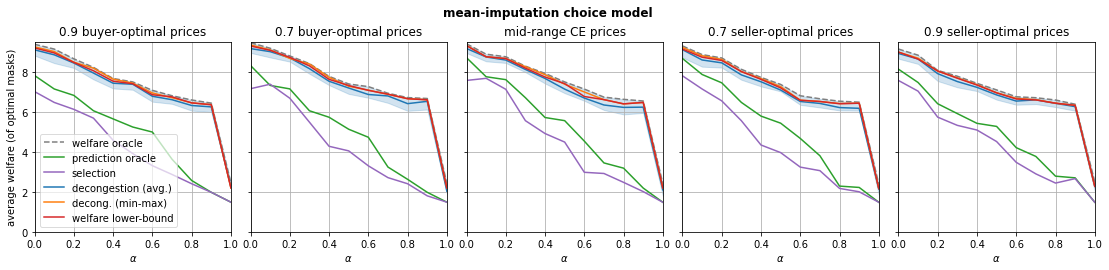

In [470]:
all_Ws, all_max_masks = res_meanimp

decong_idx = 2

names = ['welfare oracle',
         'welfare lower-bound',
         'decongestion (avg.)',
         'prediction oracle',
         'selection',
         'welfare proxy (ours)']
decong_name = 'decong. (min-max)'

colors =  ['tab:grey','tab:orange','tab:blue','tab:green','tab:purple','tab:red']
lnstyls = ['--','-','-','-','-','-']
titles = ['0.9 buyer-optimal prices','0.7 buyer-optimal prices','mid-range CE prices','0.7 seller-optimal prices','0.9 seller-optimal prices']
xticks = ['0','0.2','0.4','0.6','0.8','1']
order = [0,3,4,2,1,5]

fig, axs = plt.subplots(1,len(pis))
fig.set_size_inches(19,3.5)
for j in range(len(pis)):
    y_ = np.mean(np.asarray([all_Ws[i][j] for i in range(len(seeds))]),0) #average over seeds
    for i in range(len(fs)):
        axs[j].plot(alphas,y_[:,order[i]],lnstyls[order[i]],color=colors[order[i]])
    axs[j].set_title(titles[j]) #(f'price_range[{pis[j]:.0f}]')
    axs[j].set_xlabel(r'$\alpha$')
    if j==0:
        axs[j].set_ylabel('average welfare (of optimal masks)')
    else:
        axs[j].set_yticklabels('')
    axs[j].set_ylim(0,9.5)
    axs[j].set_xlim(0,1)
    axs[j].grid()
    if j==0: #len(pis)-1:
#         lgnd = axs[j].legend([names[i_] for i_ in order],bbox_to_anchor=(1.04, 1)) #framealpha=0.4)
        lgnd_names = [names[i_] for i_ in order]
        lgnd_names.insert(4,decong_name)
        lgnd = axs[j].legend(handles=hndls,labels=lgnd_names,framealpha=0.7)

    
clr = colors[decong_idx]
for j in range(len(pis)):
    mnmx = np.asarray([prep_mask_mnmx(all_max_masks[i][j],alphas,decong_idx)[1] for i in range(len(seeds))])
    mn = np.mean(mnmx[:,0,:],axis=0)
    mx = np.mean(mnmx[:,1,:],axis=0)
    axs[j].fill_between(alphas, mn, mx, color=clr, alpha=0.2)
plt.suptitle('mean-imputation choice model', y=1.02, fontweight='bold')
plt.subplots_adjust(wspace=0.1)


if SAVE:
    fname = 'mean_imp'
    fig.savefig(dirname + '/' + fname + '.png', format='png', bbox_inches='tight')
    fig.savefig(dirname + '/' + fname +'.pdf', format='pdf', bbox_inches='tight')

plt.show()